In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Click events - roi area



Function for set the roi Area in any video 

In [32]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

In [34]:
#setup matplotlib to use it:
%matplotlib ipympl

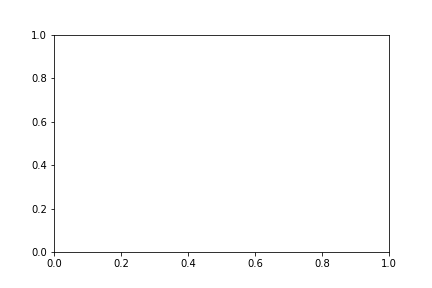

In [35]:
#Example working
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# initialize the list of reference points 
refPt = []

def onclick(event):
    coordinate = []
    ix, iy = event.xdata, event.ydata
    coordinate.append(ix)
    coordinate.append(iy)
    refPt.append(coordinate)
    print(refPt)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

Processing video....
You should click on the parts of the image you want to form part of the ROI area


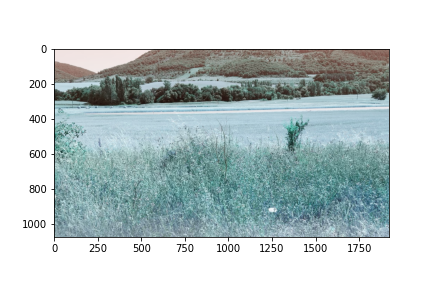

Reference points []


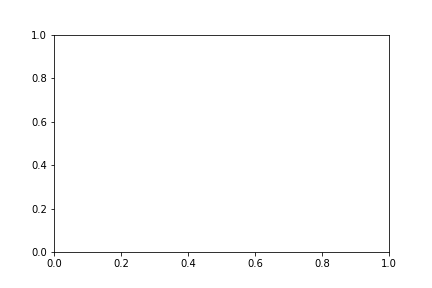

[[928.5322580645159, 195.42114695340524]]
[[928.5322580645159, 195.42114695340524], [911.327956989247, 487.89426523297504]]
[[928.5322580645159, 195.42114695340524], [911.327956989247, 487.89426523297504], [1914.912186379928, 453.48566308243744]]
[[928.5322580645159, 195.42114695340524], [911.327956989247, 487.89426523297504], [1914.912186379928, 453.48566308243744], [1903.4426523297486, 120.86917562724034]]


In [38]:
cap = cv2.VideoCapture('/content/drive/MyDrive/INGESTION/DATOS_MEDIDAS/Medidas_Junio_Aoiz/video_220613_15_54_32.MOV')
print("Processing video....")
count_frame = 0
refPt=[]
while True:
    count_frame += 1
    ret, frame = cap.read()#ret =true if one more frame exist
    if ret==False: #no more frames
      break
    height, width, _ = frame.shape

    if count_frame == 10:
      print("You should click on the parts of the image you want to form part of the ROI area")
      break
#we call the click finder function just in the first frame
plt.imshow(frame)
plt.show()
fig, ax = plt.subplots()
cid = fig.canvas.mpl_connect('button_press_event', onclick)
print("Reference points",refPt)


In [42]:
print(refPt)
print(refPt[0][1])
print(refPt[1][1])
print(refPt[0][0])
print(refPt[3][0])

[[928.5322580645159, 195.42114695340524], [911.327956989247, 487.89426523297504], [1914.912186379928, 453.48566308243744], [1903.4426523297486, 120.86917562724034]]
195.42114695340524
487.89426523297504
928.5322580645159
1903.4426523297486


In [43]:
roi = frame [int(refPt[0][1]):int(refPt[1][1]),int(refPt[0][0]):int(refPt[3][0])]

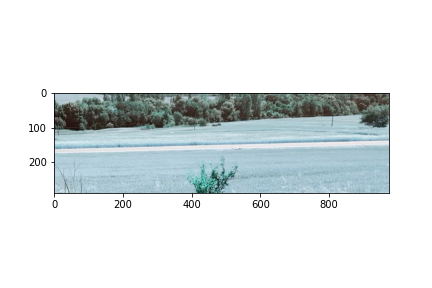

In [44]:
plt.imshow(roi)
plt.show()

# Vehicle tracker


In [45]:
####################################################################
######  FUNCTION: adapt_samples2secs
######  Para calcular los indices equidistantes de muestras (video y DAS)
# X_data_base_lista : vector equiespaciados de muestras de DAS
# X_data_frac_lista : temporal index (segundos) of samples
####################################################################
#duracion_video=180# #for video_220613_15_42_42.MOV
def adapt_samples2secs(Fp, duracion_video):
    x_data_frac = np.linspace(0, Fp.shape[0], 30 )
    x_data_base = np.linspace(0,duracion_video,30)
    X_data_frac_lista = []

    for i in x_data_frac:
        #i = round(i)
        X_data_frac_lista.append(i)
    
    X_data_base_lista = []    
    
    for i in x_data_base:
        #i= round(i)
        X_data_base_lista.append(i)
    
    return X_data_base_lista,X_data_frac_lista

####################################################################
######  FUNCTION: vehicle_type
######  Según humbral y área de ROI calcular el tipo de vehiculo
# tipos: "Heavy vehicle", "Light vehicle", "Motorcycle"
####################################################################
def vehicle_type(cnt, secs_light, secs_heavy, detections, count_frame, fps, type):
    
    area = cv2.contourArea(cnt)
    if area > 1000:
        #cv2.drawContours(roi, [cnt], -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(cnt)
        detections.append([x, y, w, h]) 
        if area<1200:
            type = "Motorcycle"
        if area>1200 and area<2500:
            type = "Light vehicle"
            #secs_light.append((round((count_frame/fps),1)))
        if area>2500:
            type = "Heavy vehicle"
            #secs_heavy.append((round((count_frame/fps),1)))
       #print("Type of vehicle",type)
    return type, secs_heavy,secs_light,detections

####################################################################
######  FUNCTION: extracting_direction
######  Dirección sentido de Vehículo
# return: close_sec, far_sec, direction, x, y, w, h, x_aux, w_aux, id, secs_heavy, secs_light
#         close_sec: segundos que pasa un coche cercano a la fibra
#         far_sec  : segundos que pasa un coche alejado a la fibra
#         direction: "Far from the fiber" , "Close to the fiber"
#         x, y, w, h: coordenadas y tamaño en el frame del coche detectado en el ROI
#         x_aux, w_aux: auxiliares = x, w output (x_aux, w_aux input son del frame anterior)
#         id : ID de cada vehiculo
#         secs_heavy : lista con los segundos cuando se dectecta en el video un veh. pesado (punto central, 756)
#         secs_light : lista con los segundos cuando se dectecta en el video un veh. ligero (punto central, 756)
####################################################################
def extracting_direction(box_id, id_aux, x_aux, w_aux, direction, count_frame, close_sec, far_sec, sec_video, fps, id_list, type, secs_heavy, secs_light):  
    x, y, w, h, id = box_id
    direction_aux = None
    if x_aux is not None:

        if x>x_aux and w>w_aux:
                direction = "Far from the fiber"    
        else :
            direction = "Close to the fiber"
        direction_aux = direction
    x_aux = x
    w_aux = w
    
    if x <= 20:
    #if x == 0 or x >= 560 :
  
        if id not in id_list:
            print("######################") 
            print("######################")
            print(type,direction_aux)
            print("######################")
            print("######################")  
            #lista con segundos del video en los que hay un vehiculo
            sec_video.append(round((count_frame/fps),2))
            
            if direction_aux == "Close to the fiber" :    
                close_sec.append(round((count_frame/fps),2))
                if type=="Light vehicle":
                    secs_light.append((round((count_frame/fps),2)))
                if type=="Heavy vehicle":
                    secs_heavy.append((round((count_frame/fps),2)))
                    
            if direction_aux == "Far from the fiber" or direction_aux == None:
                far_sec.append(round((count_frame/fps),1))
                if type=="Light vehicle":
                    secs_light.append((round((count_frame/fps),2)))
                if type=="Heavy vehicle":
                    secs_heavy.append((round((count_frame/fps),2)))
            direction_aux==None
            
        id_list.append(id)
        type = None
        
    
    if id is not None and id_aux is None:
        id_aux = id
        frame_ini = count_frame
    if id is None and id_aux is not None:
        frame_final = count_frame
        diferencia_frames = frame_final - frame_ini
        segundos_diferencia = diferencia_frames/fps
        velocidad = distancia_recorrida / segundos_diferencia #m/s
        velocidades.append(velocidad)
        print("Esta es la velocidad del vehiculo",velocidades)
    return close_sec, far_sec, direction, x, y, w, h, x_aux, w_aux, id, secs_heavy, secs_light


####################################################################
######  FUNCTION: unify_list
######  filtrado de las listas de detección de vehículo
######  (se unifican las detecciones cuando hay más de 1 en un frame o dentro de un intervalo de tiempo)
#RETURN: unique_sec, unique_sec_close, unique_sec_far, unique_secs_heavy, unique_secs_light
# MIRAR sec_video
####################################################################     
def unify_list(sec_video, close_sec, far_sec, secs_heavy, secs_light):
    #print(close_sec, far_sec)
    
    sec_video = delete_repeted_elements(sec_video)
    
    unique_sec = []
    for value in sec_video:
        if value not in unique_sec:
            unique_sec.append(value)
    unique_sec = delete_repeted_elements(unique_sec)

    close_sec = delete_repeted_elements(close_sec)
    unique_sec_close = []
    for value in close_sec:
        if value not in unique_sec_close:
            unique_sec_close.append(value)

    unique_sec_far = []
    unique_sec_far = compare_lists(unique_sec, unique_sec_close, unique_sec_far)

    unique_secs_light = []
    for sec in secs_light:
      if sec not in unique_secs_light:
        unique_secs_light.append(sec)

    secs_heavy = delete_repeted_elements(secs_heavy)
    unique_secs_heavy = []
    for sec in secs_heavy:
      if sec not in unique_secs_heavy:
        unique_secs_heavy.append(sec)

    return unique_sec, unique_sec_close, unique_sec_far, unique_secs_heavy, unique_secs_light

####################################################################
######  FUNCTION: compare_lists
######  Apaño: como en el sentido alejado de la fibra habia un vehiculo no detectado
######  Todo lo que esté en unique_sec y no está en close o nefarar, se añade a far
####################################################################  
def  compare_lists(unique_sec, unique_sec_close, unique_sec_far):
    
    for value in unique_sec:
        if value not in unique_sec_close:
            unique_sec_far.append(value)
    return unique_sec_far 

def delete_repeted_elements(unique_sec):
    int_unique_sec = []
    for i in unique_sec:
        int_unique_sec.append(int(i))
    
    dup = [x for i, x in enumerate(int_unique_sec) if i != int_unique_sec.index(x)]
    #print("elementos duplicados",dup)
    if len(dup)>0:
        #print("unique_sec antes de eliminar duplicado", unique_sec)
        unique_sec.pop()
        #print("unique_sec despues de eliminar duplicado", unique_sec)
    return unique_sec
    
def plotting_graphs(close_secs, Fp_770, muestreo):
    for i in close_secs:
        i = int(round(i))
        #dibujamos los datos en los que pasa un coche.
        print("example of a vehicle in the following sec: ", i)
        print(int(i/muestreo-150),int(i/muestreo+150))
        plt.figure(figsize=(20,5))
        plt.plot(Fp_770[int(i/muestreo-150):int(i/muestreo+150)],label="Vehicle example")
        #plt.plot(Fp_770[int(i/muestreo-50):int(i/muestreo+50)],label="Vehicle example")
        plt.plot(Fp_770[0:300],label="No traffic")
        plt.legend()
        plt.show()

In [46]:
#tracker.py en local
# Lo que detecta en cada momento el movimiento del vehículo
#RETURN: Coordendas del vehiculo en cada frame
class EuclideanDistTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 25:
                    self.center_points[id] = (cx, cy)
                    #print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

Processing video....
You should click on the parts of the image you want to form part of the ROI area


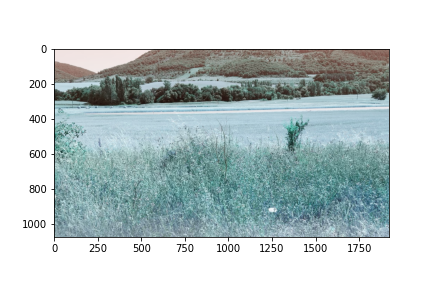

Reference points []


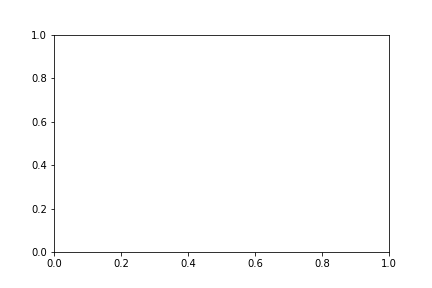

[[1060.4318996415768, 229.82974910394296]]
[[1060.4318996415768, 229.82974910394296], [1060.4318996415768, 430.546594982079]]
[[1060.4318996415768, 229.82974910394296], [1060.4318996415768, 430.546594982079], [1914.912186379928, 419.0770609318997]]
[[1060.4318996415768, 229.82974910394296], [1060.4318996415768, 430.546594982079], [1914.912186379928, 419.0770609318997], [1897.707885304659, 120.86917562724034]]


In [47]:
#cuando iniciemos con un vídeo nuevo, correr esta celda para calcular la roi correspondiente al vídeo
cap = cv2.VideoCapture('/content/drive/MyDrive/INGESTION/DATOS_MEDIDAS/Medidas_Junio_Aoiz/video_220613_15_54_32.MOV')
print("Processing video....")
count_frame = 0
refPt=[]
while True:
    count_frame += 1
    ret, frame = cap.read()#ret =true if one more frame exist
    if ret==False: #no more frames
      break
    height, width, _ = frame.shape

    if count_frame == 10:
      print("You should click on the parts of the image you want to form part of the ROI area")
      break
#we call the click finder function just in the first frame
plt.imshow(frame)
plt.show()
fig, ax = plt.subplots()
cid = fig.canvas.mpl_connect('button_press_event', onclick)
print("Reference points",refPt)


['Fp', '__globals__', '__header__', '__version__', 'distancia', 'muestreo_distancia', 'muestreo_tiempo', 'tiempo']
muestreo tiempo [[0.00520021]]
muestreo distancia [[1.03448276]]


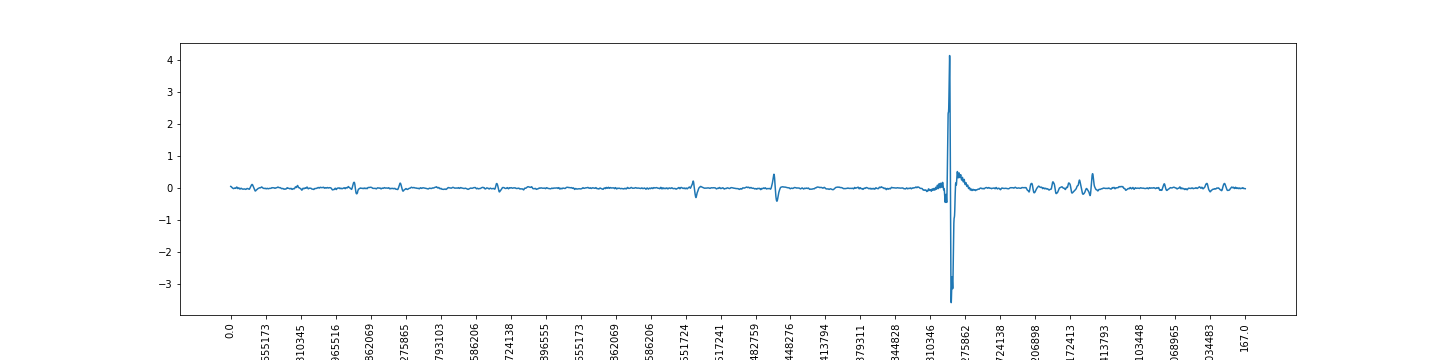

Processing video....
######################
######################
Light vehicle Close to the fiber
######################
######################
######################
######################
Motorcycle Close to the fiber
######################
######################
######################
######################
Heavy vehicle Close to the fiber
######################
######################
######################
######################
Heavy vehicle Close to the fiber
######################
######################
######################
######################
Heavy vehicle Close to the fiber
######################
######################
######################
######################
Heavy vehicle Close to the fiber
######################
######################
######################
######################
Heavy vehicle Close to the fiber
######################
######################
######################
######################
Motorcycle Close to the fiber
######################
########

In [48]:
# Create tracker object
tracker = EuclideanDistTracker()
#cap = cv2.VideoCapture('/content/drive/MyDrive/INGESTION/DATOS_MEDIDAS/Medidas_Junio_Aoiz/video_220613_15_54_32.MOV')
fps = round(cap.get(cv2.CAP_PROP_FPS))

# Object detection from Stable camera
object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=80)
x_aux = None
w_aux = None
id_aux = None
direction = None
count_frame = 0
type = None
sec_video = []
close_sec = []
far_sec = []
id_list = []
secs_light = []
secs_heavy = []
velocidades = []
distancia_recorrida = 30#m

mat = scipy.io.loadmat('/content/drive/MyDrive/INGESTION/DATOS_MEDIDAS/Medidas_Junio_Aoiz/medida_220613_15_54_32.mat') 

print(sorted(mat.keys()))
distancia=mat['distancia']
tiempo=mat['tiempo']
Fp=mat['Fp'][:,750:800]
Fp_770=mat['Fp'][:,750]

muestreo=mat['muestreo_tiempo']
muestreo_distancia =mat['muestreo_distancia']
print("muestreo tiempo",muestreo)
print("muestreo distancia",muestreo_distancia)

#plt.plot(Fp) 
plt.figure(figsize=(20,5))
plt.plot(Fp_770) 

'''
#Dibuja las trayectorias de los coches. Nos sirve para detectar cruces y en que momento se producen.
#color_mat=plt.pcolor(Fp)
color_mat=plt.pcolor(Fp,vmin=-0.3, vmax=0.3)
plt.show()
'''

#para ver segundos en el eje
duracion_video=167# for video_220613_15_42_42.MOV
X_data_base_lista, X_data_frac_lista = adapt_samples2secs(Fp, duracion_video)
plt.xticks(X_data_frac_lista, X_data_base_lista, rotation=90)   
plt.show()
print("Processing video....")
while True:
    
    #print(segundo_video)
    count_frame = count_frame + 1
    ret, frame = cap.read()#ret =true if one more frame exist
    if ret==False: #no more frames
      break
    height, width, _ = frame.shape

    # Extract Region of interest
    #roi = frame[400:500,1300:1920] #ROI for video_220613_15_42_42.MOV
    roi = frame[int(refPt[0][1]):int(refPt[1][1]),int(refPt[0][0]):int(refPt[3][0])] #ROI for video_220613_15_42_42.MOV
    # 1. Object Detection
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)
    
    #Prueba para aumentar los puntos blancos y que sea más constante.
    #cada pixel blanco se multiplica por 5 y 5 (más área para evitar multi-detecciones)
    kernel = np.ones((5,5))
    mask = cv2.dilate(mask, kernel, 1)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []    
    
    for cnt in contours:
        # function which predict the type of vehicle by the size of his mask 
        type, secs_heavy, secs_light, detections = vehicle_type(cnt, secs_light, secs_heavy, detections, count_frame, fps, type)
    
    # 2. Object Tracking
    #direction = None
    boxes_ids = tracker.update(detections)
    
    if len(boxes_ids)==0:
        x_aux = None
        w_aux = None 
        id_aux = None
    
    for box_id in boxes_ids:
        close_sec, far_sec, direction, x, y, w, h, x_aux, w_aux, id, secs_heavy, secs_light  = extracting_direction(box_id, id_aux, x_aux, w_aux, direction, count_frame, close_sec, far_sec, sec_video, fps, id_list, type, secs_heavy, secs_light)        
        #print(box_id)
        cv2.putText(roi, str(id), (x, y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
        cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.putText(frame, str(direction), (800, y + 200), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
        cv2.putText(frame, str(type), (800, y + 300), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
    '''
    cv2.imshow("roi", roi)
    #cv2.imshow("Frame", frame)
    cv2.imshow("Mask", mask)
    '''
    unique_sec, unique_sec_close, unique_sec_far, unique_secs_heavy, unique_secs_light = unify_list(sec_video, close_sec, far_sec, secs_heavy, secs_light)
    
    #plotting_graphs(unique_sec_close, Fp_770, muestreo)
    
    key = cv2.waitKey(30)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()  
      

In [49]:
19500*muestreo


array([[101.40405616]])

In [50]:
#TARGET: 15 (13 light+2 heavy) detections for video_220613_15_42_42.MOV
#seconds    : 6.2	8.2	10	17.8	36.4	42.3	45.8	94.4	101.8	110.5	113.2	122.4	139	146	174.2
#timestamps : 15:42:48	15:42:50	15:42:52	15:42:59	15:43:18	15:43:24	15:43:27	15:44:16	15:44:23	15:44:32	15:44:35	15:44:44	15:45:01	15:45:08	15:45:36
#min:sec    : 0:6	0:8	0:10	0:18	0:36	0:42	0:46	1:34	1:42	1:51	1:53	2:2	2:19	2:26	2:54
#           : <	<	>	<	<	<	<	<	<(h)	<	<	<(h)	<	>	<
print("all the vehicles",unique_sec)
print("Number of Vehicles: ",len(unique_sec))  
print("Vehicles close to the fiber:", unique_sec_close)
print("Number of Vehicles close to the fiber: ",len(unique_sec_close))
print("Vehicles far from the fiber:", unique_sec_far)
print("Number of Vehicles far from the fiber: ",len(unique_sec_far))
print("Light vehicles",unique_secs_light)
print("Number of light vehicles: ",len(unique_secs_light))
print("Heavy vehicles",unique_secs_heavy)
print("Number of heavy vehicles: ",len(unique_secs_heavy))

all the vehicles [2.44, 4.28, 5.4, 19.52, 27.24, 43.32, 78.32, 91.8, 108.72, 120.72, 134.52, 138.32, 141.04, 142.76, 144.16, 153.6, 160.56, 163.36, 171.56, 188.24, 193.0]
Number of Vehicles:  21
Vehicles close to the fiber: [2.44, 4.28, 5.4, 19.52, 27.24, 43.32, 142.76, 144.16, 153.6, 160.56, 163.36, 188.24]
Number of Vehicles close to the fiber:  12
Vehicles far from the fiber: [78.32, 91.8, 108.72, 120.72, 134.52, 138.32, 141.04, 171.56, 193.0]
Number of Vehicles far from the fiber:  9
Light vehicles [2.44, 19.52, 27.24, 43.32, 91.8, 108.72, 120.72, 134.52, 141.04, 142.76, 144.16, 153.6, 160.56, 163.36, 171.56]
Number of light vehicles:  15
Heavy vehicles [4.44, 5.4, 188.24]
Number of heavy vehicles:  3


# Calculate correlation coeficients

In [51]:
# Functions to find the optimal measuring point (m)
def mean(List):
    total = 0
    for a in List:
        total += float(a)
    mean = total/len(List)
    return mean
def standDev(List):
    listMean = mean(List)
    dev = 0.0
    for i in range(len(List)):
        dev += (List[i]-listMean)**2
    dev = dev**(1/2.0)
    return dev
def correl_coef(List1, List2):

    # First establish the means and standard deviations for both lists.
    xMean = mean(List1)
    yMean = mean(List2)
    xStandDev = standDev(List1)
    yStandDev = standDev(List2)
    # r numerator
    rNum = 0.0
    for i in range(len(List1)):
        rNum += (List1[i]-xMean)*(List2[i]-yMean)

    # r denominator
    rDen = xStandDev * yStandDev

    r =  rNum/rDen
    return r

In [52]:
#ejemplo de coeficiente de correlación entre dos listas
Fp = mat['Fp'][:,750]
x = Fp 
peaks, _ = find_peaks(x, height=0.1,distance=200)
segundos_señal = peaks/(1/muestreo)
segundos_señal = segundos_señal.tolist()[0]
print(segundos_señal)
segundos_video = unique_sec
print(segundos_video)
correl_coef(segundos_video[0:10], segundos_señal[0:10])

[3.536141445657826, 20.426417056682265, 28.065522620904833, 44.035361414456574, 76.5730629225169, 89.94279771190847, 117.86791471658866, 119.0275611024441, 120.30681227249089, 121.42485699427976, 132.60010400416016, 136.13624544981798, 138.76755070202807, 140.53042121684865, 142.69890795631824, 154.56578263130524, 161.62246489859592, 164.54498179927197]
[2.44, 4.28, 5.4, 19.52, 27.24, 43.32, 78.32, 91.8, 108.72, 120.72, 134.52, 138.32, 141.04, 142.76, 144.16, 153.6, 160.56, 163.36, 171.56, 188.24, 193.0]


0.9298309302870105

sale superalto (pero mirando el tercer número ya está comparando cifras diferentes... mal! (6 con 6 bien), (8 con 8 bien) (17 con 9 mal!!!).

Asi que mejor calcular cuantos indices son comprables

In [53]:
#max_index: max. num. de indeces comparables
#Función que calcula el número de indices que vamos a tener en cuenta para la correlación entre la lista de los segundos en los que pasa un coche en el vídeo y 
# los segundos en los que hay un pico en la señal.Este indice es muy importante, ya que en el caso de ser 1, no se tendrá en cuenta el coeficciente de correlación
# si no la diferencia entre dos valores. El primer valor de cada lista.
def max_index(indice_max, x):
  peaks, _ = find_peaks(x, height=0.1,distance=200)
  segundos_señal = peaks/(1/muestreo)
  segundos_señal= segundos_señal.tolist()[0]
  for j in range(len(segundos_video)) :
    if j < (len(segundos_señal)):
      if (segundos_señal[j]-segundos_video[j]) > abs(2):
        print("Me quedo en el siguiente indice:", j)
        
    else:
      if j < indice_max:
          indice_max = j
      break
  return indice_max

In [54]:
#CALCULATING THE METER WHERE THE CAMERA IS POINTING TO
coef_max = 0
dif_min = 999
index = None
indice_max = 999
segundos_video = unique_sec #segundos_video = [6.2, 8.2, 10.0, 17.8, 36.4, 42.3, 45.8, 94.4, 101.8, 110.5, 113.2, 122.4, 139.0, 146.0, 174.2]

for i in range(725,775):
  Fp = mat['Fp'][:,i]
  x = Fp 
  indice_max = max_index(indice_max, x)
  print(indice_max)
for i in range(725,775):
  Fp = mat['Fp'][:,i]
  x = Fp
  peaks, _ = find_peaks(x, height=0.1,distance=200)
  segundos_señal = peaks/(1/muestreo)
  segundos_señal= segundos_señal.tolist()[0]

  if indice_max >= 2:
    coef = correl_coef(segundos_video[0:indice_max], segundos_señal[0:indice_max])
    print("Coeficiente y metro",coef,i)
    if coef>coef_max:
      coef_max = coef
      index = i
  if indice_max == 1:
    #diferencia
    dif = segundos_video[0] - segundos_señal[0]
    print(dif)
    if dif < abs(dif_min):
      dif_min = dif
      index = i      
if indice_max == 1:
  print("El índice máximo es 1, tendremos en cuenta la diferencia entre los dos primeros valores de ambas listas:")
  print("La mejor diferencia ",dif_min,"y el metro es: ", index)
else:
  print("Tendremos en cuenta el coeficiente de correlación, el índice máximo es mayor que uno:")
  print("El mayor coeficiente de correlación es: ",coef_max," y el metro es: ",index)

  

Me quedo en el siguiente indice: 0
Me quedo en el siguiente indice: 1
Me quedo en el siguiente indice: 2
Me quedo en el siguiente indice: 3
Me quedo en el siguiente indice: 4
Me quedo en el siguiente indice: 5
Me quedo en el siguiente indice: 6
Me quedo en el siguiente indice: 7
Me quedo en el siguiente indice: 8
Me quedo en el siguiente indice: 9
Me quedo en el siguiente indice: 10
Me quedo en el siguiente indice: 11
Me quedo en el siguiente indice: 12
Me quedo en el siguiente indice: 13
14
Me quedo en el siguiente indice: 0
Me quedo en el siguiente indice: 1
Me quedo en el siguiente indice: 2
Me quedo en el siguiente indice: 3
Me quedo en el siguiente indice: 4
Me quedo en el siguiente indice: 5
Me quedo en el siguiente indice: 6
Me quedo en el siguiente indice: 7
Me quedo en el siguiente indice: 8
Me quedo en el siguiente indice: 9
Me quedo en el siguiente indice: 10
Me quedo en el siguiente indice: 11
Me quedo en el siguiente indice: 12
Me quedo en el siguiente indice: 13
14
Me que

In [55]:
muestreo

array([[0.00520021]])

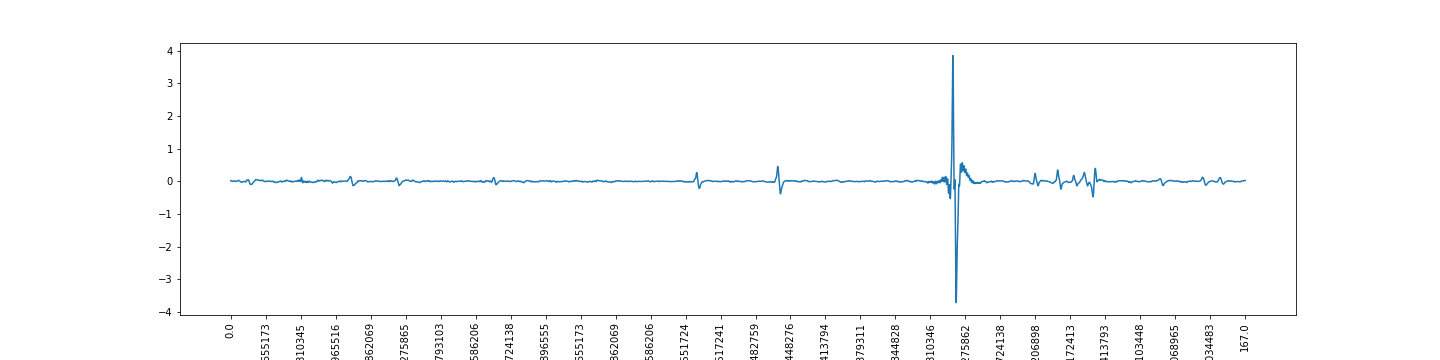

[[11.710868434737389, 19.807592303692147, 27.457098283931355, 43.562142485699425, 77.15548621944878, 90.57202288091523, 118.40873634945397, 119.57358294331773, 121.11804472178886, 122.24648985959438, 133.1721268850754, 136.92147685907435, 139.57358294331772, 141.33125325013, 143.1461258450338, 160.8996359854394, 163.84295371814872]]


In [56]:
Fp_m=mat['Fp'][:,index]
plt.figure(figsize=(20,5))
plt.plot(Fp_m)
plt.xticks(X_data_frac_lista, X_data_base_lista, rotation=90)   
plt.show()
x = Fp_m
peaks_m, _ = find_peaks(x, height=0.1,distance=200)
segundos_señal_m = peaks_m/(1/muestreo)
segundos_señal_m = segundos_señal_m.tolist()
print(segundos_señal_m)

In [ ]:
'''
#Fp metro: muestro ejemplos de las graficas en el momento que pasa un coche (los 15), comparando con "no vehiculo"
Fp_m=mat['Fp'][:,index]#index :el punto donde está la cámara (750)

muestreo=0.005200208008320333
print(segundos_señal_m)
plotting_graphs(segundos_señal_m, Fp_m, muestreo)
'''

In [57]:
Fp.shape[0]*muestreo

array([[167.9875195]])

In [58]:
Fp.shape[0]*0.005200208008320333

167.98751950078002

In [59]:
muestreo
#0.005200208008320333

array([[0.00520021]])

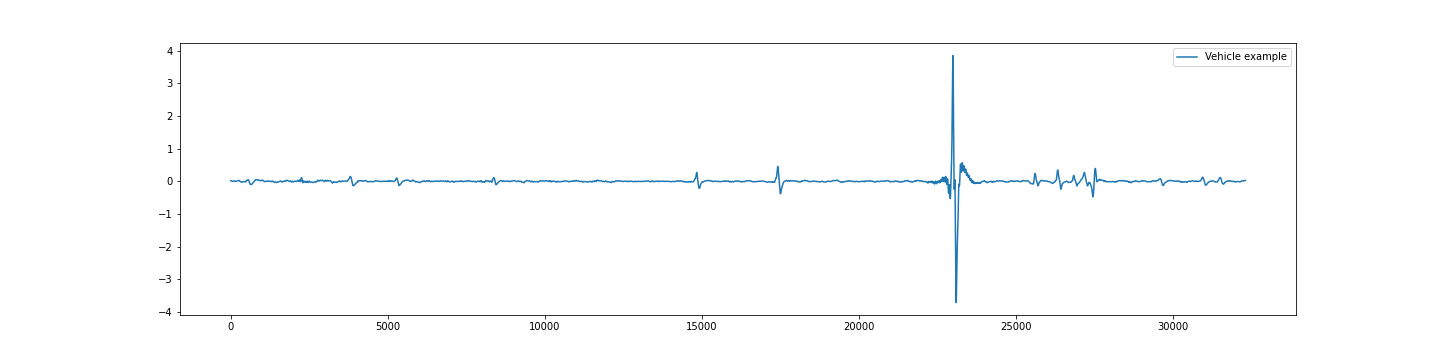

In [60]:
plt.figure(figsize=(20,5))
plt.plot(Fp_m[:],label="Vehicle example")
plt.legend()
plt.show()

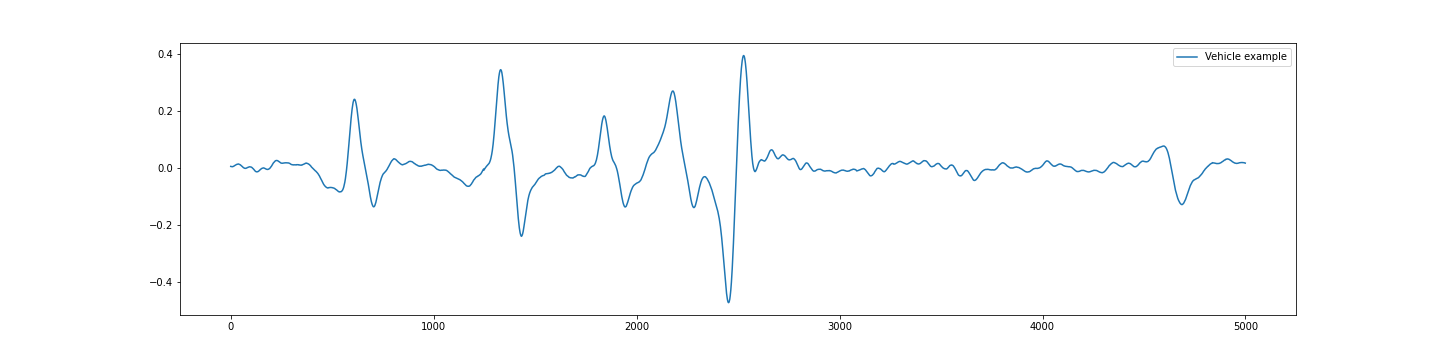

In [61]:
plt.figure(figsize=(20,5))
plt.plot(Fp_m[25000:30000],label="Vehicle example")
plt.legend()
plt.show()

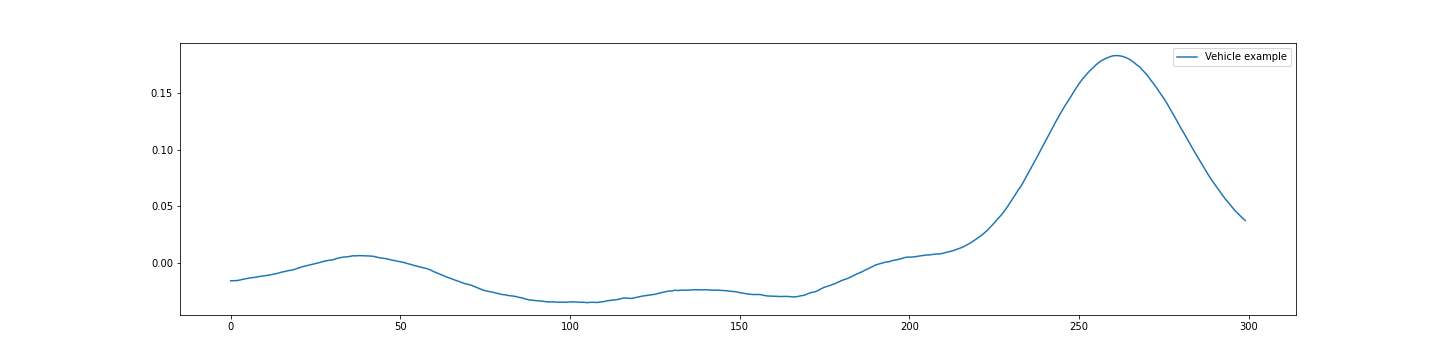

In [62]:
plt.figure(figsize=(20,5))
plt.plot(Fp_m[26579:26879],label="Vehicle example")
plt.legend()
plt.show()

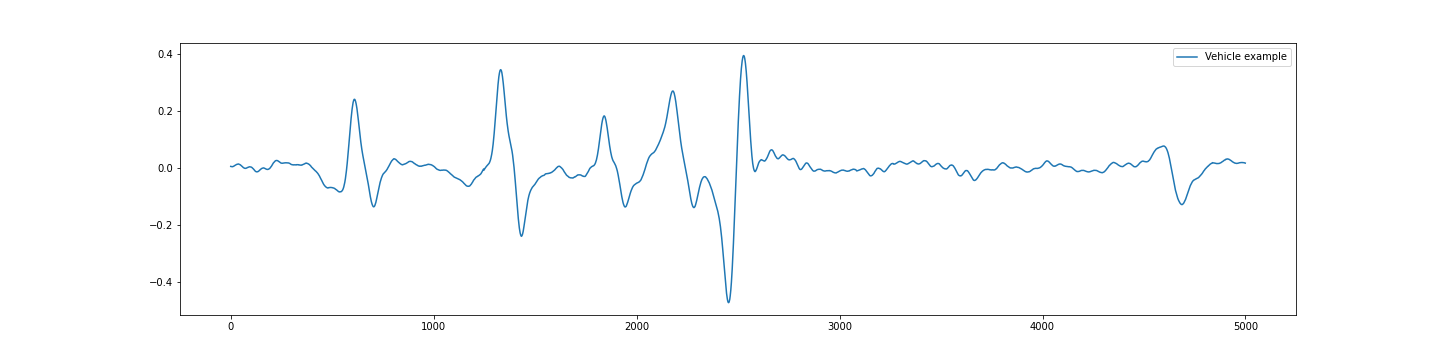

In [63]:
plt.figure(figsize=(20,5))
plt.plot(Fp_m[25000:30000],label="Vehicle example")
plt.legend()
plt.show()

In [64]:
Fp.shape

(32304,)

It seems that the video does not cover all the DAS data ( the last light vehicle is out of dataframe range)

In [65]:
print(segundos_señal_m)
print(unique_sec)

[[11.710868434737389, 19.807592303692147, 27.457098283931355, 43.562142485699425, 77.15548621944878, 90.57202288091523, 118.40873634945397, 119.57358294331773, 121.11804472178886, 122.24648985959438, 133.1721268850754, 136.92147685907435, 139.57358294331772, 141.33125325013, 143.1461258450338, 160.8996359854394, 163.84295371814872]]
[2.44, 4.28, 5.4, 19.52, 27.24, 43.32, 78.32, 91.8, 108.72, 120.72, 134.52, 138.32, 141.04, 142.76, 144.16, 153.6, 160.56, 163.36, 171.56, 188.24, 193.0]


# Creating training dataframe

In [ ]:
#voy a buscar un valor concreto de la lista con todos los segundos en los que pasa un coche y le vamos a buscar en el resto de listas para etiquetarlo en una clase u otra.
import pandas as pd

vehicleType = []
direction = []
data = []
for sec in unique_sec:
  if sec in unique_sec_close:
    direction.append("Close to the fiber")
    if sec in unique_secs_heavy:
      vehicleType.append("Heavy")
    else:
      vehicleType.append("Light")
    Fp_sec = Fp_m[int(sec/muestreo-100):int(sec/muestreo+100)]
    data.append(Fp_sec)
  if sec in unique_sec_far:
    direction.append("Far from the fiber")
    if sec in unique_secs_heavy:
      vehicleType.append("Heavy")
    else:
      vehicleType.append("Light")
    Fp_sec=Fp_m[int(sec/muestreo-100):int(sec/muestreo+100)]
    data.append(Fp_sec)


datos = pd.DataFrame (data)
datos.insert(0,'Type of vehicle',vehicleType)
datos.insert(1,'Direction' , direction)

datos


In [ ]:
datos

In [ ]:
def find_nearest(array, value): 
  array = np.asarray(array) 
  idx = (np.abs(array - value)).argmin() 
  return array[idx]


In [ ]:
array = segundos_señal_m
comun = []
result = []
for value in unique_sec:
  comun.append(find_nearest(array, value))
for item in comun:
    if item not in result:
        result.append(item)
result
print(len(result))

In [ ]:
#Fp metro: muestro ejemplos de las graficas en el momento que pasa un coche (los 15), comparando con "no vehiculo"
Fp_m=mat['Fp'][:,index]#index :el punto donde está la cámara (750)

muestreo=0.005200208008320333

plotting_graphs(result, Fp_m, muestreo)